In [84]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12)

import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.datasets import StroopSRODataset, CogPonderDataModule
from pathlib import Path

In [85]:
# this notebook only fits one SRO subject, which its SRO-SubjectID can be defined here
SRO_SUBJECT_ID = 202

# upon successful training, the model will be saved to this path
CHECKPOINT_PATH = Path('models/stroop/') / f'cogponder_subject-{SRO_SUBJECT_ID}_epochs-10000.ckpt'

BATCH_SIZE = 72

In [86]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

print('loading data module...', end='')
dataset = StroopSRODataset(n_subjects=-1, response_step_interval=10)
data = dataset[SRO_SUBJECT_ID]
datamodule = CogPonderDataModule(data, batch_size=BATCH_SIZE, num_workers=8)
datamodule.prepare_data()
print('Done!')

X, trial_types, is_corrects, y_true, rt_true = datamodule.test_dataset[:]

with torch.no_grad():
    model_ckpt.eval()

    print('Predicting responses...', end='')
    y_pred_steps,p_halts,rt_pred = model_ckpt(X)

    y_pred_steps = torch.argmax(y_pred_steps, dim=-1)

    y_pred = y_pred_steps.gather(dim=0, index=rt_pred[None, :] - 1,)[0]  # (batch_size,)

    print('Done!')


loading data module...Done!
Predicting responses...Done!


In [87]:
non_decision_time = (
    dataset.non_decision_time[SRO_SUBJECT_ID] + dataset.response_step_interval * data[4].min()
)

average_human_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_true * dataset.response_step_interval + non_decision_time,
    'accuracy': (X[:,1] == y_true).float() * 100,
    'agent': 'Human data',
})

human_performance = pd.DataFrame({
    'condition': trial_types,
    'response_time': rt_true * dataset.response_step_interval + non_decision_time,
    'accuracy': (X[:,1] == y_true).float() * 100,
    'agent': 'Human data',
})

cogponder_performance = pd.DataFrame({
    'condition': trial_types,
    'response_time': rt_pred * dataset.response_step_interval + non_decision_time,
    'accuracy': (X[:,1] == y_pred).float() * 100,
    'agent': 'CogPonder agent'
})

average_cogponder_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_pred * dataset.response_step_interval + non_decision_time,
    'accuracy': (X[:,1] == y_pred).float() * 100,
    'agent': 'CogPonder agent',
})

plot_data = pd.concat([human_performance, average_human_performance,
                       cogponder_performance, average_cogponder_performance]).reset_index()

plot_data['condition'] = plot_data['condition'].map({-1: 'All', 0: 'Incongruent', 1: 'Congruent'})

plot_data = plot_data.melt(id_vars=['condition', 'agent'],
               value_vars=['response_time', 'accuracy'],
               var_name='measure'
               )

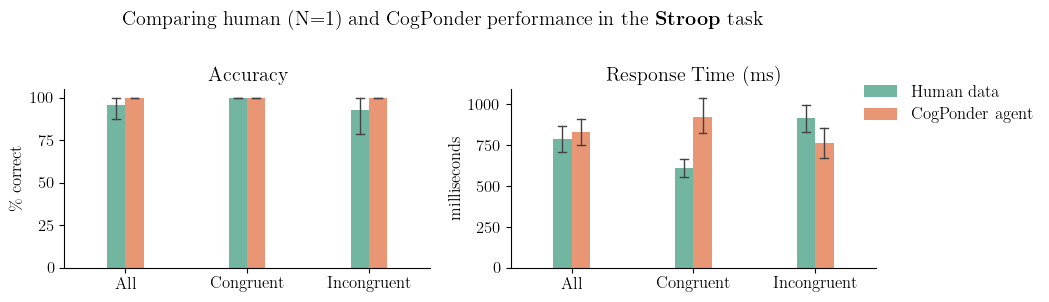

In [88]:
g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['All', 'Congruent', 'Incongruent'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('\% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('milliseconds')
g.axes[0,1].set_title('Response Time (ms)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human (N=1) and CogPonder performance in the \\textbf{Stroop} task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

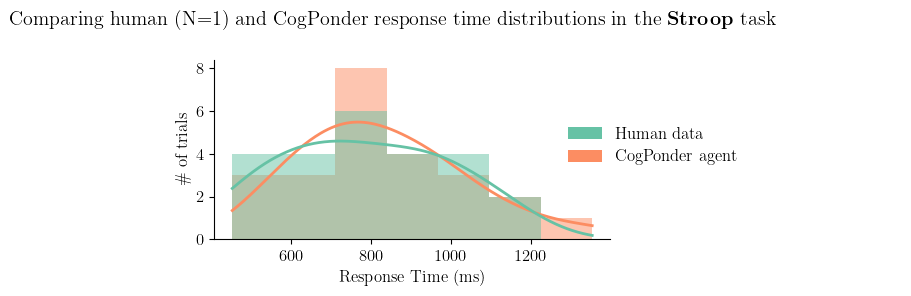

In [94]:
# Figure 4

plot_data = pd.DataFrame({
    'rt_true': rt_true * dataset.response_step_interval + non_decision_time,
    'rt_pred': rt_pred * dataset.response_step_interval + non_decision_time,
}).melt()

g = sns.displot(
    data=plot_data, x='value', hue='variable',
    kind='hist', kde=True, fill=True, common_norm=False,
    lw=0, alpha=.5, height=3, aspect=1.2,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette='Set2',
    hue_order=['rt_true', 'rt_pred'],
    legend=True
)

# replace labels
g._legend.set_title(None)
g.legend.set_bbox_to_anchor((1.6, .5))
for t, l in zip(g._legend.texts, ['Human data', 'CogPonder agent']):
    t.set_text(l)

g._legend.legendHandles[0].set_alpha(1)
g._legend.legendHandles[1].set_alpha(1)

g.ax.set(xlabel='Response Time (ms)', ylabel='\# of trials')

plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the \\textbf{Stroop} task')
plt.tight_layout()
plt.savefig('outputs/figures/figure4-stroop.png', bbox_inches='tight', dpi=300)
plt.show()